## Model Evaluation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                           classification_report, confusion_matrix)
import json
import torch
import os
from datetime import datetime


In [ ]:
eval_results = trainer.evaluate()

Basic Evaluation Results:
eval_loss: 0.3193
eval_runtime: 223.9609
eval_samples_per_second: 125.1200
eval_steps_per_second: 15.6410
epoch: 0.2141

Generating predictions for detailed analysis...

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.86     14395
    Positive       0.85      0.86      0.86     13627

    accuracy                           0.86     28022
   macro avg       0.86      0.86      0.86     28022
weighted avg       0.86      0.86      0.86     28022



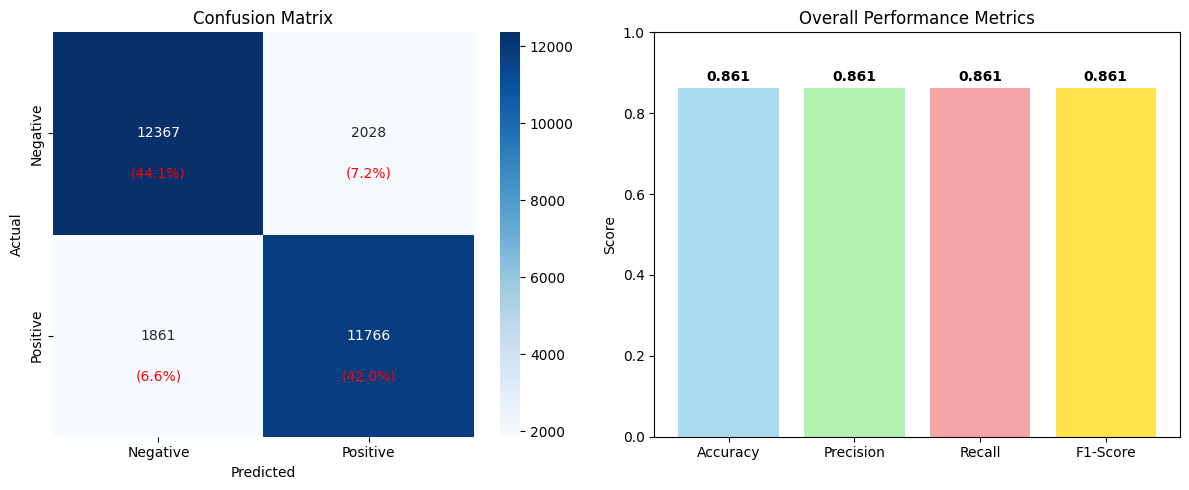

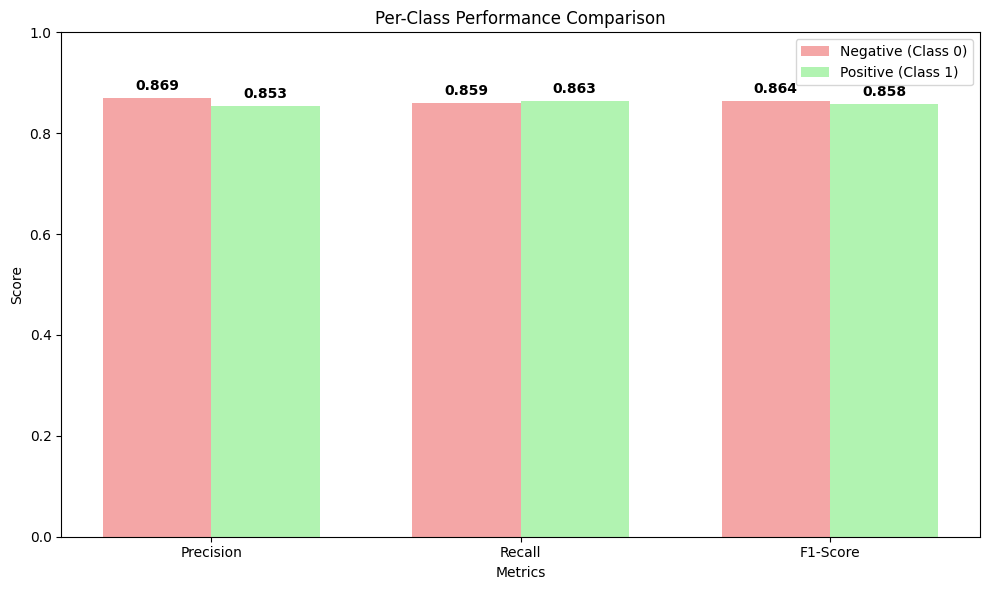

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Basic Evaluation Results:")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

print("\nGenerating predictions for detailed analysis...")
predictions = trainer.predict(tokenized_dataset["test"])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

detailed_metrics = {
    "model_info": {
        "model_name": MODEL_NAME,
        "num_labels": 2,
        "evaluation_date": datetime.now().isoformat(),
        "device": str(device)
    },
    "overall_metrics": {
        "accuracy": float(accuracy),
        "weighted_precision": float(precision_avg),
        "weighted_recall": float(recall_avg),
        "weighted_f1": float(f1_avg)
    },
    "per_class_metrics": {
        "class_0_negative": {
            "precision": float(precision[0]),
            "recall": float(recall[0]),
            "f1_score": float(f1[0]),
            "support": int(support[0])
        },
        "class_1_positive": {
            "precision": float(precision[1]),
            "recall": float(recall[1]),
            "f1_score": float(f1[1]),
            "support": int(support[1])
        }
    },
    "confusion_matrix": confusion_matrix(y_true, y_pred).tolist(),
    "classification_report": classification_report(y_true, y_pred, 
                                                 target_names=['Negative', 'Positive'],
                                                 output_dict=True)
}

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / total * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.subplot(1, 2, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, precision_avg, recall_avg, f1_avg]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

bars = plt.bar(metrics_names, metrics_values, color=colors, alpha=0.7)
plt.title('Overall Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
x = np.arange(3)
width = 0.35

class_0_metrics = [precision[0], recall[0], f1[0]]
class_1_metrics = [precision[1], recall[1], f1[1]]

plt.bar(x - width/2, class_0_metrics, width, label='Negative (Class 0)', 
        color='lightcoral', alpha=0.7)
plt.bar(x + width/2, class_1_metrics, width, label='Positive (Class 1)', 
        color='lightgreen', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Per-Class Performance Comparison')
plt.xticks(x, ['Precision', 'Recall', 'F1-Score'])
plt.legend()
plt.ylim(0, 1)

for i, (v0, v1) in enumerate(zip(class_0_metrics, class_1_metrics)):
    plt.text(i - width/2, v0 + 0.01, f'{v0:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.text(i + width/2, v1 + 0.01, f'{v1:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

save_directory = "/kaggle/working/game_review_bert_model"
os.makedirs(save_directory, exist_ok=True)

with open('/kaggle/working/evaluation_metrics.json', 'w') as f:
    json.dump(detailed_metrics, f, indent=2)

with open(f'{save_directory}/evaluation_metrics.json', 'w') as f:
    json.dump(detailed_metrics, f, indent=2)

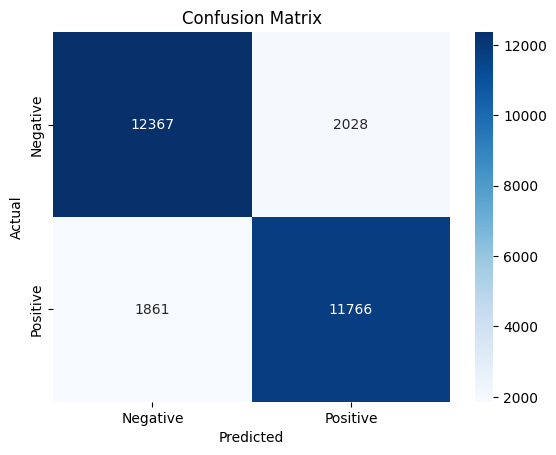

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('./game_review_bert_model/confusion_matrix.png')

## Sample Prediction

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text = "This game is amazing!"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Move input tensors to the same device as the model
inputs = {key: value.to(device) for key, value in inputs.items()}

# Now run inference
with torch.no_grad():  # Optional: saves memory during inference
    outputs = model(**inputs)
    predicted_class = outputs.logits.argmax().item()
    
print("Predicted:", predicted_class)

Predicted: 1
